In [1]:
import os
import re
import numpy as np            
import pandas as pd           
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
sc.logging.print_versions()

stype = "CD4"
oDir = os.path.abspath("./OUT_Fig3")

if not os.path.exists(oDir):
    os.makedirs(oDir)
os.chdir(oDir)

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
backcall            0.1.0
bbknn               NA
cffi                1.12.3
colorama            0.4.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.0
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.17
ipykernel           5.1.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.13.3
joblib              0.13.2
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.35.0
louvain             0.6.1
matplotlib          3.4.1
mpl_toolkits        NA
natsort             6.0.0
numba               0.52.0
numexpr             2.6.9
numpy               1.19.5
packaging           19.0
pandas              1.1.5
parso               0.4.0
pexpect       

In [2]:
adata = sc.read(f"{oDir}/../../data/expression/{stype}/integration/{stype}.expr.txt.gz", delimiter="\t",first_column_names=True)

Only considering the two last: ['.txt', '.gz'].
Only considering the two last: ['.txt', '.gz'].


In [3]:
## add cellInfo
cellInfo = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.miniInfo.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
cellInfo = cellInfo.loc[list(adata.obs_names), [not bool(re.match('RNA_', i)) for i in cellInfo.columns] ]
adata.obs = cellInfo
#
adata.obs['cancerType'] = [re.sub('\\..*', '', i) for i in np.array(adata.obs.dataset)]

In [4]:
## add reduction
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}.pca.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
redim1 = redim1.loc[list(adata.obs_names), :]
adata.obsm['X_pca'] = np.array(redim1)

In [5]:
## add colSet
adata.obs["meta.cluster"] = adata.obs["meta.cluster"].astype('category')
color = pd.read_csv(f"{oDir}/../../data/metaInfo/color_meta.cluster_.txt.gz", compression="gzip", sep="\t", header=None, index_col=0)
color_used = list(color.loc[adata.obs["meta.cluster"].cat.categories,1])
adata.uns['meta.cluster_colors'] = color_used

# Run

In [6]:
sc.pp.neighbors(adata, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15


/data2/qss/01.software/miniconda3/lib/python3.7/site-packages/numba/core/typed_passes.py:316: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../01.software/miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/data2/qss/01.software/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

    finished (0:00:04)


In [7]:
## diffusion map
sc.tl.diffmap(adata, n_comps=10)

computing Diffusion Maps using n_comps=10(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9876451  0.9809706  0.96946716 0.95856386 0.957216
     0.9462338  0.93810177 0.9362894  0.9300242 ]
    finished (0:00:00)


... storing 'dataset' as categorical
... storing 'dataset.tech' as categorical
... storing 'ClusterID.pca' as categorical
... storing 'ClusterID.harmony' as categorical
... storing 'meta.cluster.coarse' as categorical
... storing 'cancerType' as categorical


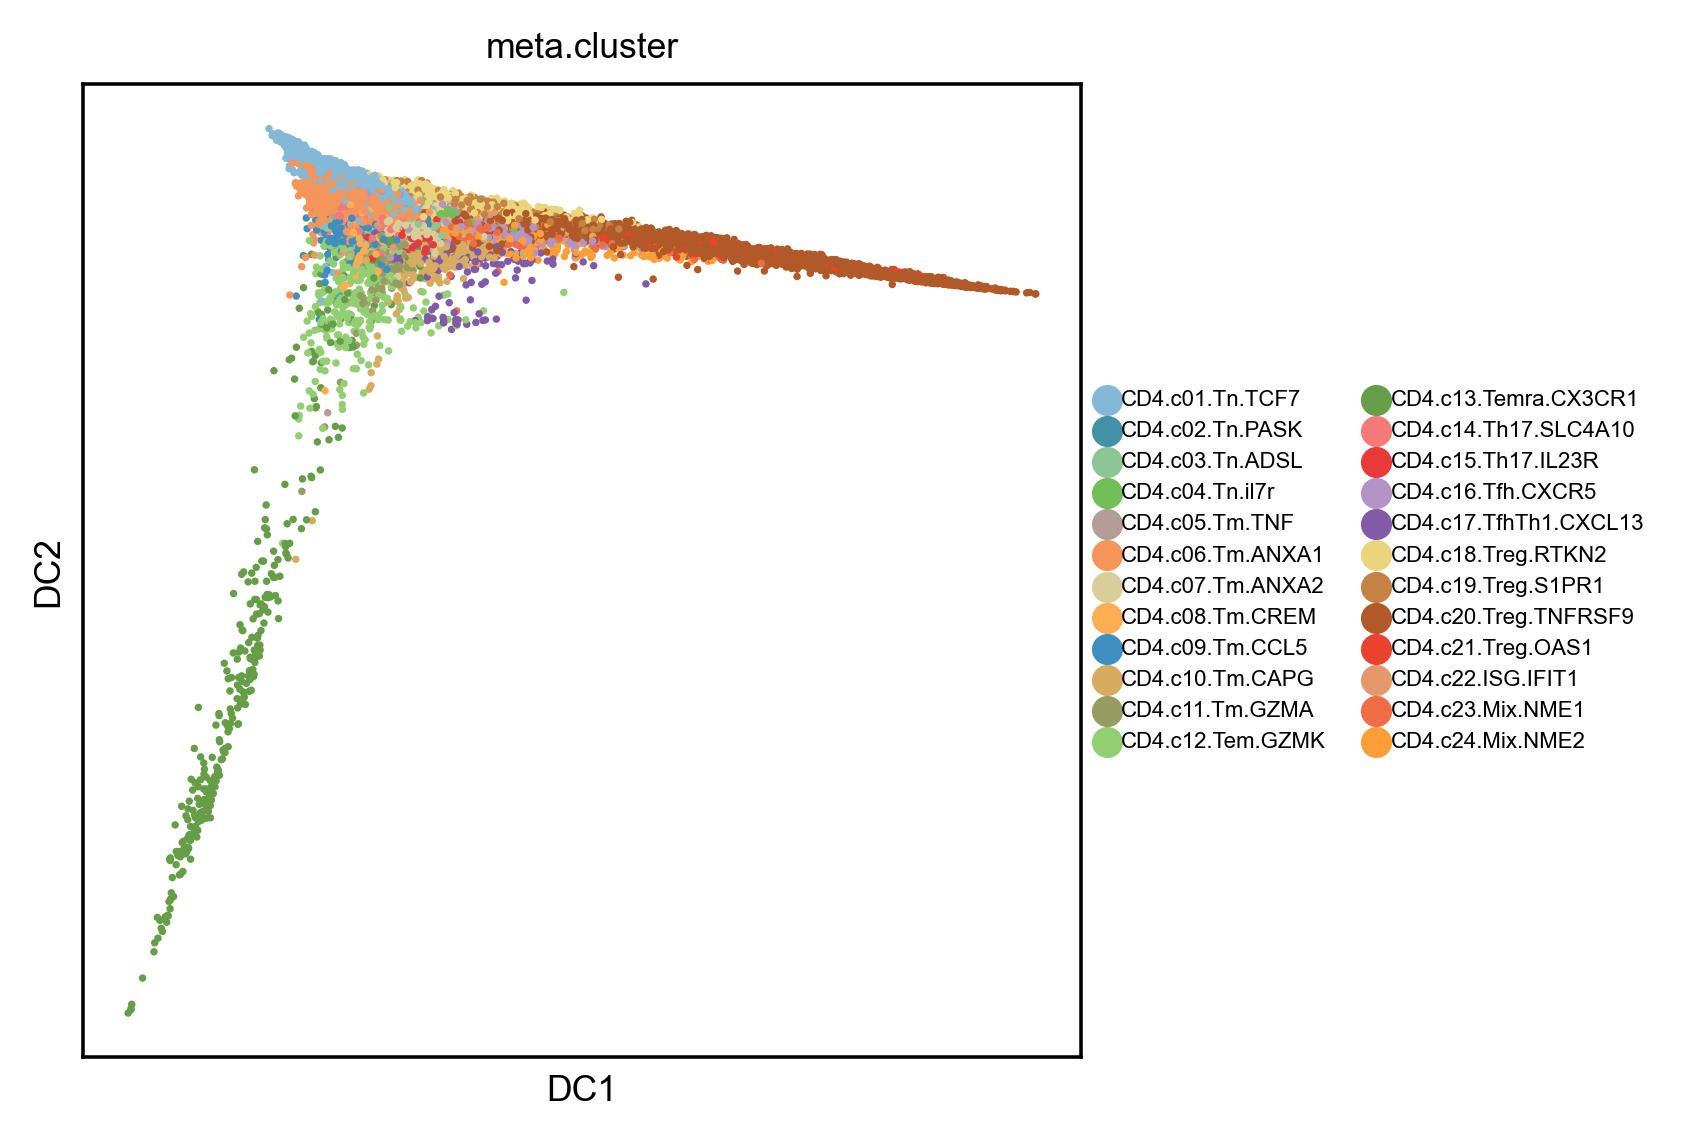

In [8]:
sc.set_figure_params(dpi=160, color_map='viridis', fontsize=8)
sc.pl.embedding(adata, basis='diffmap', color=['meta.cluster'],
                legend_loc='right margin', legend_fontsize=5,
                save=f".{stype}_global.pdf")

In [9]:
## save
adata.write(f"{oDir}/{stype}.sc.h5ad")
diff = pd.DataFrame(adata.obsm['X_diffmap'], index=adata.obs_names)
diff.to_csv(f"{oDir}/{stype}.diffMap.txt", sep="\t")